In [2]:
%load_ext autoreload
%autoreload 2

import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
from darts import TimeSeries
from darts.utils.data import tabularization as tab
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from darts.metrics import mape, r2_score, rmse
from darts.models import RegressionModel

import utils

warnings.filterwarnings('ignore')

In [3]:
# Load data
df = utils.load_data()

# Convert the dataframe to multiple TimeSeries objects (one per pre-processing method)
ts, covars_diff, covars_diff_yoy, covars_nodiff = utils.df2ts(df)

# Scale the time series and covariates
covars_diff_pipeline, covars_diff_scaled = utils.scale_ts(covars_diff, should_diff=True, diff_order=1, should_scale=True, should_log=True)
covars_nodiff_pipeline, covars_nodiff_scaled = utils.scale_ts(covars_nodiff, should_diff=False, should_scale=True, should_log=True)
covars_diff_yoy_pipeline, covars_diff_yoy_scaled = utils.scale_ts(covars_diff_yoy,should_diff=True, diff_order=12, should_scale=True, should_log=True)
pipeline, ts_scaled = utils.scale_ts(ts, should_diff=True, diff_order=1, should_scale=True, should_log=True)


# Ensure that all timeseries are aligned (i.e. have the same time range). This is required for stacking them together.
covars_diff_scaled = covars_diff_scaled.slice_intersect(covars_diff_yoy_scaled)
covars_nodiff_scaled = covars_nodiff_scaled.slice_intersect(covars_diff_yoy_scaled)

# Stack the covariates
covariates_scaled = covars_diff_scaled.stack(covars_nodiff_scaled).stack(covars_diff_yoy_scaled)


# Split the data into training and validation sets
train_ts, val_ts = ts.split_after(pd.Timestamp("2016-01-01"))
train_ts_scaled, val_ts_scaled = ts_scaled.split_after(pd.Timestamp("2016-01-01"))
train_covariates_scaled, val_covariates_scaled = covariates_scaled.split_after(pd.Timestamp("2016-01-01"))

# Reconvert to DataFrame since statsmodels does not support TimeSeries objects
train = train_ts_scaled.pd_dataframe()
validation = val_ts_scaled.pd_dataframe()
history = pd.concat([train, validation])

# Model Selection

In [4]:
ts_lags = list(range(-12, 0))


lags_past_covariates = {covar: list(range(-3, 0)) for covar in covariates_scaled.components}


X_train, y_train, times, last_static_covariates_shape, sample_weight = tab.create_lagged_training_data(
    target_series=train_ts_scaled,
    past_covariates=train_covariates_scaled,
    output_chunk_length=1,
    output_chunk_shift=1,
    lags=ts_lags,
    lags_past_covariates=lags_past_covariates,
    uses_static_covariates=False,
)
X_train = X_train.squeeze()
y_train = y_train.squeeze()


X_test, y_test, times, last_static_covariates_shape, sample_weight = tab.create_lagged_training_data(
    target_series=val_ts_scaled,
    past_covariates=val_covariates_scaled,
    output_chunk_length=1,
    output_chunk_shift=1,
    lags=ts_lags,
    lags_past_covariates=lags_past_covariates,
    uses_static_covariates=False,
)
X_test = X_test.squeeze()
y_test = y_test.squeeze()

In [5]:
features_cols_names, label_cols_names = tab.create_lagged_component_names(
    ts_scaled, covariates_scaled, lags=ts_lags, lags_past_covariates=lags_past_covariates, concatenate=False
)

X_train = pd.DataFrame(X_train, columns=features_cols_names)
y_train = pd.DataFrame(y_train, columns=label_cols_names)

X_test = pd.DataFrame(X_test, columns=features_cols_names)
y_test = pd.DataFrame(y_test, columns=label_cols_names)
X_test.head()

,US_TB_YIELD_10YRS_target_lag-12,US_TB_YIELD_10YRS_target_lag-11,US_TB_YIELD_10YRS_target_lag-10,US_TB_YIELD_10YRS_target_lag-9,US_TB_YIELD_10YRS_target_lag-8,US_TB_YIELD_10YRS_target_lag-7,US_TB_YIELD_10YRS_target_lag-6,US_TB_YIELD_10YRS_target_lag-5,US_TB_YIELD_10YRS_target_lag-4,US_TB_YIELD_10YRS_target_lag-3,...,NEWS_SENTIMENT_pastcov_lag-1,US_PERSONAL_SPENDING_PCE_pastcov_lag-1,US_UNEMPLOYMENT_RATE_pastcov_lag-1,EXPINF10YR_pastcov_lag-1,TOTBKCR_pastcov_lag-1,AWHMAN_pastcov_lag-1,W068RCQ027SBEA_pastcov_lag-1,STDSL_pastcov_lag-1,STDSL_1_pastcov_lag-1,US_CPI_pastcov_lag-1
0,-0.474715,-0.960974,0.400932,-0.233351,0.044717,-0.489915,-0.417751,0.213808,0.284084,0.481045,...,0.388754,-0.115604,-0.177429,1.611441,-0.638487,-0.005700,-0.009563,-0.313163,-1.651435,-0.367032
1,-0.960974,0.400932,-0.233351,0.044717,-0.489915,-0.417751,0.213808,0.284084,0.481045,1.279380,...,0.512311,-0.057690,-0.374650,-0.186515,-0.285073,-0.005700,-0.022087,-0.189859,-1.660470,-0.302790
2,0.400932,-0.233351,0.044717,-0.489915,-0.417751,0.213808,0.284084,0.481045,1.279380,1.188898,...,0.705791,0.741807,-0.009652,0.061085,0.328547,-0.005700,-0.022091,0.056748,-1.655049,-0.199997
3,-0.233351,0.044717,-0.489915,-0.417751,0.213808,0.284084,0.481045,1.279380,1.188898,-0.153189,...,0.862594,0.204503,0.009041,-0.222537,-0.138625,-0.378373,-0.022091,0.044419,-1.650351,0.026050
4,0.044717,-0.489915,-0.417751,0.213808,0.284084,0.481045,1.279380,1.188898,-0.153189,-0.002843,...,0.969976,-0.018863,-0.204311,-0.168143,-0.186849,0.739631,-0.058135,0.241703,-1.634089,0.303969


In [10]:
timeseries_crossval = TimeSeriesSplit(n_splits=10)
# model = linear_model.LassoCV(cv=timeseries_crossval, n_alphas=50)
model = linear_model.Lasso(alpha=0.15)
sfs = SequentialFeatureSelector(
    model, k_features=(1, 10), scoring="neg_mean_squared_error", forward=True, floating=True, cv=timeseries_crossval
)
selected_features = sfs.fit(X_train, y_train)

# Variables sélectionnées

In [11]:
selected_features.k_feature_names_

('US_TB_YIELD_10YRS_target_lag-12',
 'US_TB_YIELD_10YRS_target_lag-7',
 'US_UNEMPLOYMENT_RATE_pastcov_lag-3',
 'STICKCPIM157SFRBATL_pastcov_lag-3',
 'MICH_pastcov_lag-2',
 'STICKCPIM157SFRBATL_pastcov_lag-2',
 'US_UNEMPLOYMENT_RATE_pastcov_lag-2',
 'US_TB_YIELD_5YRS_pastcov_lag-1',
 'YIELD_CURVE_pastcov_lag-1',
 'EXPINF10YR_pastcov_lag-1')

In [32]:
selected_features.subsets_

{1: {'feature_idx': (62,),
  'cv_scores': array([-1.64273381, -0.60000414, -0.55968726, -0.59257394, -0.56523776,
         -0.66223955, -0.36270472, -0.78095019, -0.50452995, -0.28121203]),
  'avg_score': -0.6551873356103897,
  'feature_names': ('W068RCQ027SBEA_pastcov_lag-1',)},
 2: {'feature_idx': (0, 62),
  'cv_scores': array([-1.65252781, -0.61872482, -0.54199016, -0.5504058 , -0.54075187,
         -0.65599614, -0.35905996, -0.82609576, -0.51740938, -0.25738308]),
  'avg_score': -0.652034479379654,
  'feature_names': ('US_TB_YIELD_10YRS_target_lag-12',
   'W068RCQ027SBEA_pastcov_lag-1')},
 3: {'feature_idx': (0, 62, 68),
  'cv_scores': array([-1.65252781, -0.60000414, -0.54928279, -0.55186558, -0.52168941,
         -0.6579861 , -0.36044475, -0.82844031, -0.51808161, -0.25725776]),
  'avg_score': -0.6497580260038376,
  'feature_names': ('US_TB_YIELD_10YRS_target_lag-12',
   'W068RCQ027SBEA_pastcov_lag-1',
   'STICKCPIM157SFRBATL_pastcov_lag-1')},
 4: {'feature_idx': (0, 7, 62, 68),


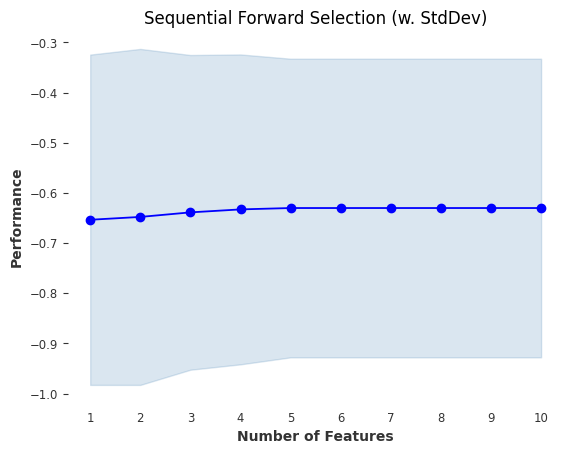

In [18]:
fig1 = plot_sfs(sfs.get_metric_dict(), kind="std_dev")

# plt.ylim([0.8, 1])
plt.title("Sequential Forward Selection (w. StdDev)")
plt.grid()
plt.show()